# Summary
In this part, the goal is to train a regressor like in Ex1, but this time we remove the analytical ground truth values for the log-probabilites, and replace them with predicted values from an INN, which can be calculated from its change-of-variables term. We track the KL divergence of our model´s logprobs with the KDE´s during training, and plot distrubitions of snapshots of the model during training.\
We also check if our own realNVP implementation or the FrEIA module works better. From now on, we only compare our predicted logprobs to the KDE´s, but the KDE no longer effects training, which removes one source of uncertainty.\
We also compare the performance of our own realNVP implementation and that of the FrEIA package and examine whether correct initialization of the weights makes a difference.\
We notice that the INN is much faster, probably due to it not needing inference with the KDE.
# Takeaway
The INN´s CVF-based density distributions are a lot "tighter" than those learned based on the ground-truth. This could mean, that the KDE´s estimation of the two-moons distribution is not good.\
The learned distributions look good, but there is a fair amount of leakage between both moons. Optimally, a KL divergence (with the possibly corrupted KDE distribution) of around 10^-3 can be reached.
# Accuracy
**MMD of INN samples: 1,3e-3**\
**KL divergence of regressor trained on INN-CVF logprobs: 6e-3** (looks bad)
# TODO
Find out why performance of regressor worsens signifacntly when using the training scheme from ex4 (loading the batch before training to reduce the expense of inference). KL with distribution from INN CVF stagnates at 2e-2, while KL divergence of ex4 minimizes as far as 1.e-5


In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from torch.utils.data import DataLoader, Dataset

import distributions as d
import evaluation as e
import models as m
import FrEIA.modules as Fm
import FrEIA.framework as Ff

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import itertools
import copy
import time

import optuna
from optuna.trial import TrialState

c:\Users\Fritz\anaconda3\envs\analyzing_invs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Global parameters

In [2]:
n_dim = 2
device ="cpu"

# INN Training parameters

In [18]:
subnet_hidden_dim = 20
n_blocks = 32
inn_batchsize = 100
inn_epochs = 4000
inn_lr = 0.0002
subnet_hidden_layers = 2

# Train INN

In [19]:
inn = m.realNVP(n_dim, subnet_hidden_dim, n_blocks, subnet_hidden_layers=subnet_hidden_layers)
inn, inn_metrics, models = m.train_inn(inn, 
                                     batchsize=inn_batchsize, 
                                     epochs=inn_epochs, 
                                     lr=inn_lr)

100%|██████████| 4000/4000 [03:45<00:00, 17.71it/s]


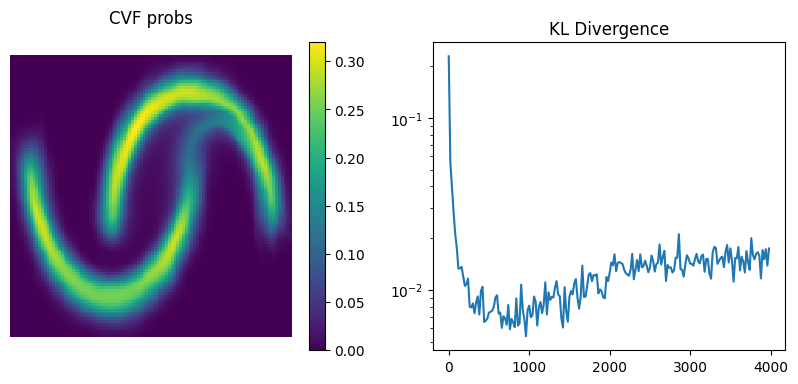

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs = axs.flatten()


e.contour_plot(inn, cvf=True, ax=axs[0])
axs[0].set_title("CVF probs")

axs[1].plot(inn_metrics["kl"][0], inn_metrics["kl"][1])
axs[1].set_title("KL Divergence")
axs[1].set_yscale("log")

# Contour plot of probabilities during training

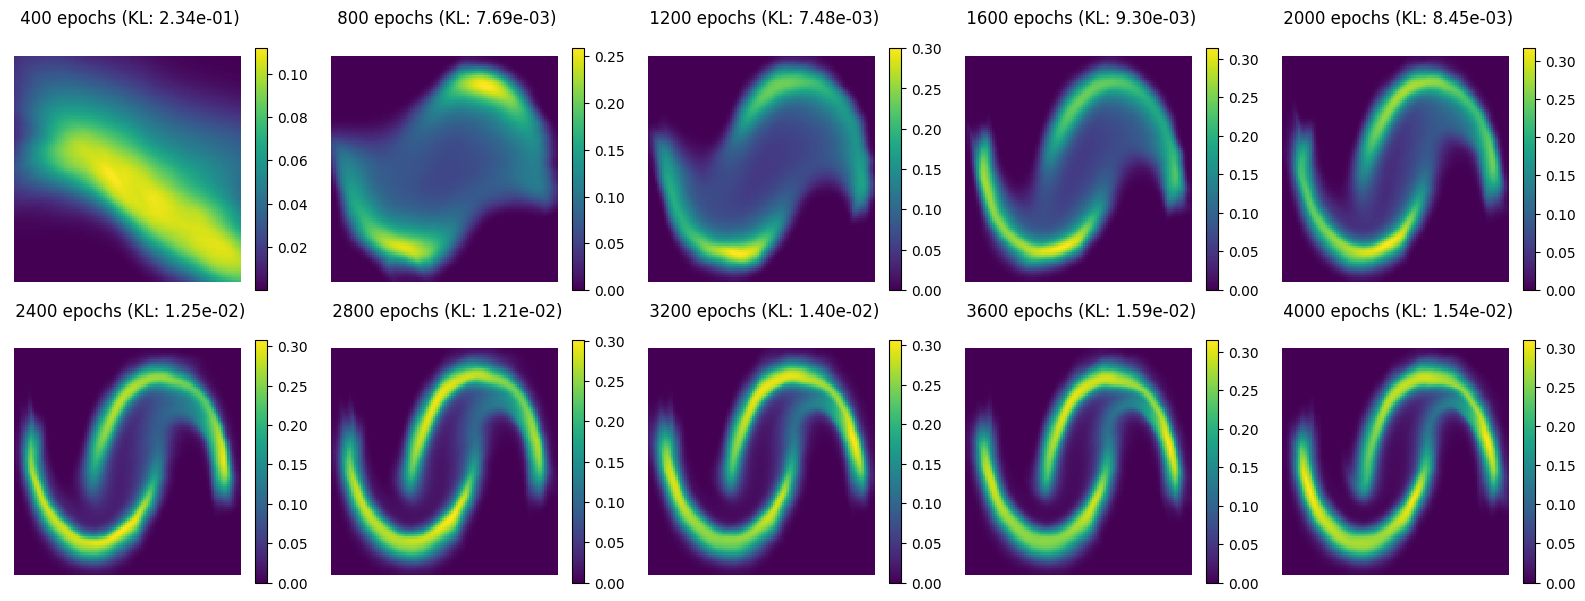

In [21]:
fig, axs = plt.subplots(2, 5, figsize=((16, 6)))
axs = axs.flatten()

for i in range(10):
    j = int(i * (inn_epochs / 200))
    epoch = int((i+1) * (inn_epochs / 10))
    if i == 10: j=-1
    e.contour_plot(models[j], cvf=True, ax=axs[i])
    axs[i].set_title(f" {epoch} epochs (KL: {e.kldiv(models[j], cvf=True).mean().item():.2e})")

    axs[i].axis("off")
plt.tight_layout()
plt.show()

# MMD test of INN

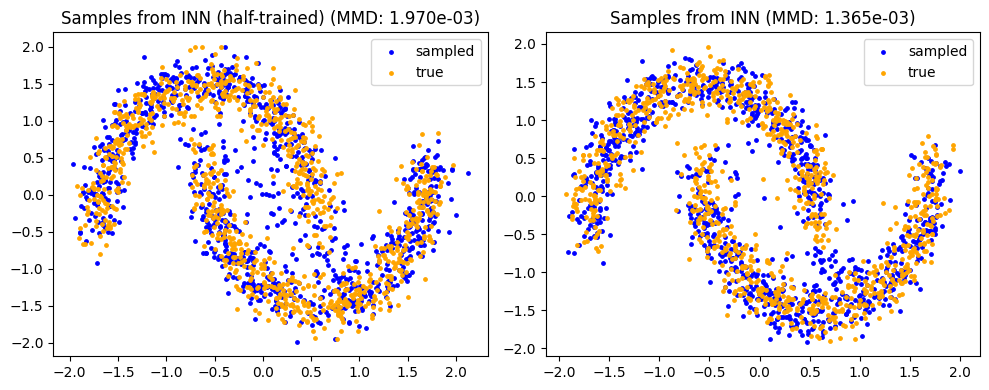

In [22]:
x, _ = make_moons(1000, noise=0.1)
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x = torch.Tensor(x_normalized)

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs = axs.flatten()

halftrained_inn = models[int(inn_epochs/40)]

e.plot_inn_samples(halftrained_inn, show_true=True, axs=axs[0])
samples_halftrained = halftrained_inn(torch.randn((1000, 2)), rev=True)
mmd_halftrained = e.mmd_inverse_multi_quadratic(x, samples_halftrained)
axs[0].set_title(f"Samples from INN (half-trained) (MMD: {mmd_halftrained:.3e})")

e.plot_inn_samples(inn, show_true=True, axs=axs[1])
samples_inn = inn(torch.randn((1000, 2)), rev=True)
mmd_inn = e.mmd_inverse_multi_quadratic(x, samples_inn)
axs[1].set_title(f"Samples from INN (MMD: {mmd_inn:.3e})")

plt.tight_layout()
plt.show()

# Functions for regressor training

In [13]:
def train_regressor_fast(model, x, logprobs,  lr=1e-4, epochs=10, 
                    batchsize=500, trial=None):
    optim = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    assert logprobs.shape[0] == x.shape[0]
    n_samples = x.shape[0]
    n_batches = n_samples // batchsize
    
    kld_history = []
    metrics = {}
    model_snapshots = []

    for epoch in tqdm.tqdm(range(epochs)):
        indices = torch.autograd.Variable(torch.randperm(n_samples), requires_grad=False)
        shuffled_x = torch.autograd.Variable(x[indices], requires_grad=False)
        shuffled_logprobs = torch.autograd.Variable(logprobs[indices], requires_grad=False)
        
        for i in range(n_batches):
            optim.zero_grad()
            
            pred = model(shuffled_x[i*batchsize:(i+1)*batchsize,:])
            
            kld_loss = torch.mean(e.generalized_kl(pred, shuffled_logprobs[i*batchsize:(i+1)*batchsize]))
            
            kld_loss.backward()
            
            optim.step()
            
            kld_history.append(kld_loss.item())
            
            model_snapshots.append(copy.deepcopy(model))
        if trial is not None: trial.report(kld_loss.item(), epoch)
    metrics["kld_loss"] = kld_history
    return model, metrics, model_snapshots

def train_regressor(model, inn,  lr=1e-4, epochs=1000, 
                    batchsize=500, trial=None):
    optim = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    kld_history = []
    metrics = {}
    model_snapshots = []

    for epoch in tqdm.tqdm(range(epochs)):
        optim.zero_grad()
        
        x, _ = make_moons(batchsize, noise=0.1)
        scaler = StandardScaler()
        x_normalized = scaler.fit_transform(x)
        x = torch.Tensor(x_normalized)
        target = inn.logprob(x)
            
        pred = model(x)
        
        kld_loss = torch.mean(e.generalized_kl(pred, target))
        
        kld_loss.backward()
        
        optim.step()
        
        kld_history.append(kld_loss.item())
          
        if epoch%(epochs//10)==0:  
            model_snapshots.append(copy.deepcopy(model))
            
        if trial is not None: trial.report(kld_loss.item(), epoch)
        
    metrics["kld_loss"] = kld_history
    
    return model, metrics, model_snapshots

# Parameters for regressor training

In [28]:
regressor_hidden_dim = 275
n_layers = 3
regressor_batchsize = 600
regressor_lr = 0.0001
regressor_epochs = 500
n_samples = 100000

# Prepare data

In [10]:
# x, _ = make_moons(n_samples, noise=0.1)
# x = torch.Tensor(x)
# scaler = StandardScaler()
# x_normalized = scaler.fit_transform(x)
# x = torch.Tensor(x_normalized)

# logprobs = []

# n_batches = 50
# assert n_samples%n_batches==0
# index = n_samples // n_batches
# for i in tqdm.tqdm(range(n_batches)):
#     batch = x[i*index:(i+1)*index,:]
#     logprobs.append(inn.logprob(batch))
#     time.sleep(.2)
# logprobs = torch.cat(logprobs)

100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


# Train regressor with CVF logprobs from INN

In [29]:
regressor = m.make_regressor(n_dim, regressor_hidden_dim, n_layers)

# regressor, metrics, models = train_regressor_fast(regressor, 
#                                     x=x,
#                                     logprobs=logprobs, 
#                                     epochs=regressor_epochs, 
#                                     batchsize=regressor_batchsize, 
#                                     lr=regressor_lr)

regressor, metrics, models = train_regressor(regressor, 
                                    inn=inn, 
                                    epochs=regressor_epochs, 
                                    batchsize=regressor_batchsize, 
                                    lr=regressor_lr)

100%|██████████| 500/500 [00:41<00:00, 12.16it/s]


10


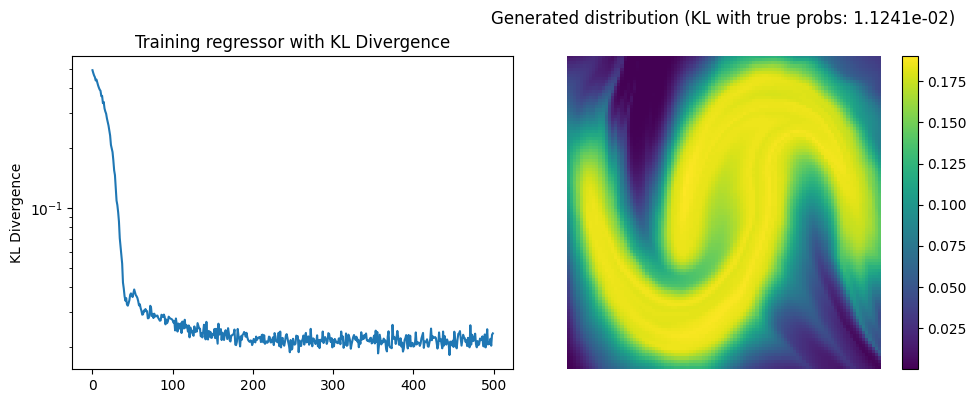

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

axs[0].plot(metrics["kld_loss"])
axs[0].set_ylabel("KL Divergence")
axs[0].set_yscale("log")
axs[0].set_title("Training regressor with KL Divergence")

e.contour_plot(regressor, axs[1], encoder=inn)
axs[1].set_title(f"Generated distribution (KL with true probs: {e.kldiv(regressor, encoder=inn).mean().item():.4e})")

plt.tight_layout()
plt.show()

# Contour plot of distributions during training

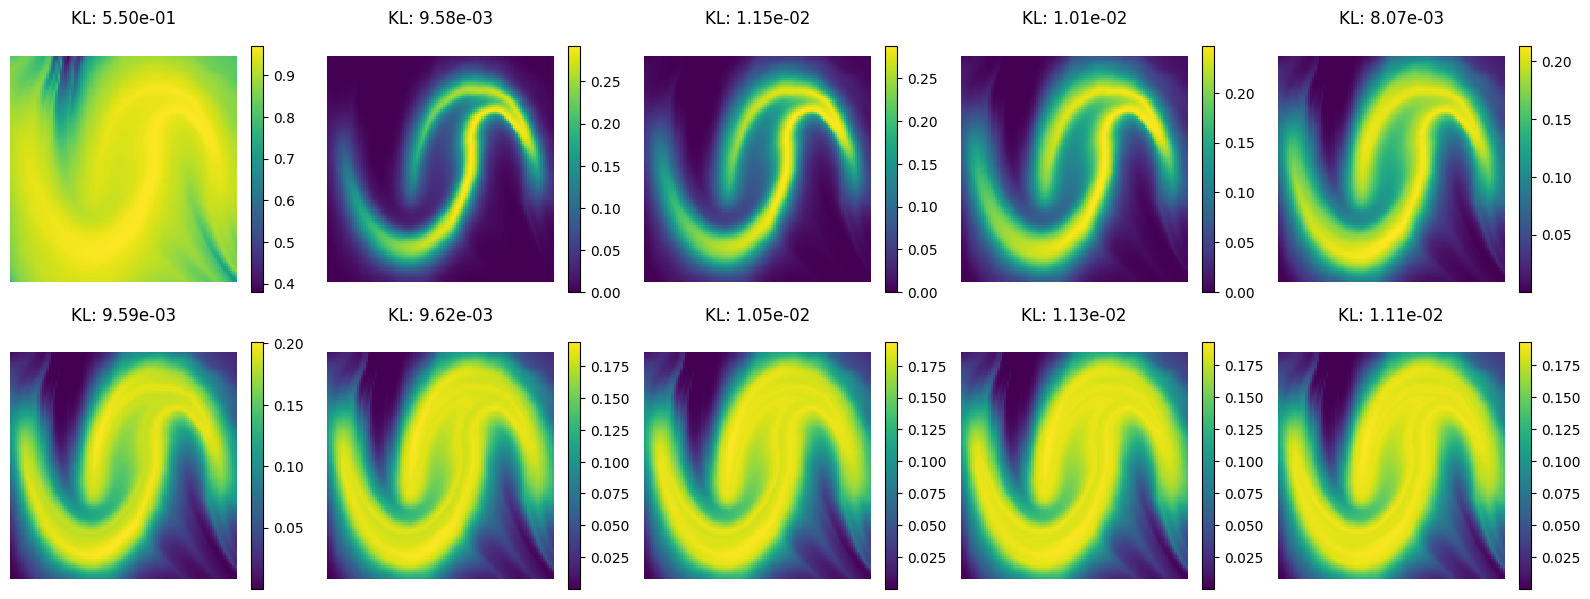

In [31]:
fig, axs = plt.subplots(2, 5, figsize=((16, 6)))
axs = axs.flatten()

for i in range(10):
    e.contour_plot(models[i], ax=axs[i], encoder=inn)
    axs[i].set_title(f"KL: {e.kldiv(models[i], encoder=inn).mean().item():.2e}")

    axs[i].axis("off")
plt.tight_layout()
plt.show()

# KL divergences between distributions (KDE, CVF, regressor)

In [ ]:
x, _ = make_moons(1000, noise=0.1)
x = torch.Tensor(x)
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x = torch.Tensor(x_normalized)

moons_dist = d.moons_distribution()
kde_dist = torch.Tensor(moons_dist.score_samples(x)).float().to(device)

inn_dist = inn.logprob(x)
regressor_dist = regressor(x)
# kldiv = torch.nn.KLDivLoss(log_target=True, reduction="batchmean")
print(f"KL(regressor, KDE): {e.generalized_kl(regressor_dist, kde_dist).mean().item():.4e}")
print(f"KL(CVF, KDE):       {e.generalized_kl(inn_dist, kde_dist).mean().item():.4e}")
print(f"KL(regressor, CVF):  {e.generalized_kl(regressor_dist, inn_dist).mean().item():.4e}")

KL(regressor, KDE): 1.2228e-02
KL(CVF, KDE):       1.2000e-02
KL(regressor, CVF):  2.0079e-02


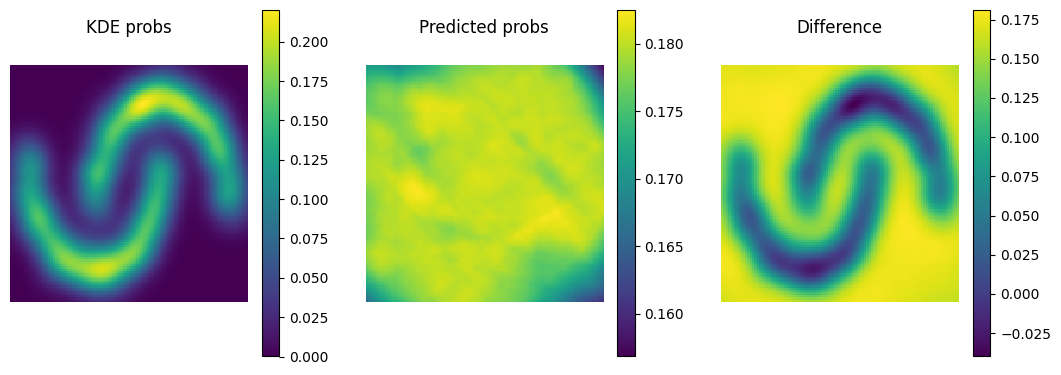

In [ ]:
grid = torch.stack(torch.meshgrid(torch.linspace(-2., 2., 100), torch.linspace(-2., 2., 100), indexing='xy'))
grid = grid.reshape(2, -1).T
moons_dist = d.moons_distribution()

fig, axs = plt.subplots(1, 3, figsize=(13,4.5))

kde_probs = torch.exp(torch.Tensor(moons_dist.score_samples(grid)).float().to(device))
pred = torch.exp(regressor(grid))

cax0 = axs[0].matshow(kde_probs.detach().numpy().reshape(100,100))
axs[0].axis("off")
axs[0].set_title("KDE probs")
cbar0 = fig.colorbar(cax0)

cax1 = axs[1].matshow(pred.detach().numpy().reshape(100,100))
axs[1].axis("off")
axs[1].set_title("Predicted probs")
cbar1 = fig.colorbar(cax1)

cax2 = axs[2].matshow(pred.detach().numpy().reshape(100,100) - kde_probs.detach().numpy().reshape(100,100))
axs[2].axis("off")
axs[2].set_title("Difference")
cbar2 = fig.colorbar(cax2)

plt.show()

# Comparison with FrEIA implementation

In [ ]:
subnet_hidden_dim = 20
subnet_hidden_layers = 2
n_blocks = 32
xavier = True

In [ ]:
def subnet_fc(dims_in, dims_out):
    linear1 = nn.Linear(dims_in, subnet_hidden_dim)
    if xavier:
        torch.nn.init.xavier_uniform_(linear1.weight)
        if linear1.bias is not None:
            torch.nn.init.zeros_(linear1.bias)
        
    hidden_layers = []
    for _ in range(subnet_hidden_layers):
        linear = nn.Linear(subnet_hidden_dim,  subnet_hidden_dim)
        if xavier:
            torch.nn.init.xavier_uniform_(linear.weight)
            if linear.bias is not None:
                torch.nn.init.zeros_(linear.bias)
        hidden_layers.append(linear)
        hidden_layers.append(nn.ReLU())
        
    linearout = nn.Linear(subnet_hidden_dim,  dims_out)
    if xavier:
        torch.nn.init.xavier_uniform_(linearout.weight)
        if linearout.bias is not None:
            torch.nn.init.zeros_(linearout.bias)
    
    return nn.Sequential(linear1, nn.ReLU(),
                         *hidden_layers,
                         linearout)
    
# a simple chain of operations is collected by ReversibleSequential
freia_inn = Ff.SequenceINN(n_dim)
for k in range(n_blocks):
    freia_inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

In [ ]:
freia_inn = m.realNVP(n_dim, subnet_hidden_dim, n_blocks)
freia_inn, freia_inn_metrics, freia_models = m.train_inn(freia_inn, 
                        batchsize=inn_batchsize, 
                        epochs=inn_epochs, 
                        lr=inn_lr)

100%|██████████| 4000/4000 [03:06<00:00, 21.42it/s]


AttributeError: 'Sequential' object has no attribute 'logprob'

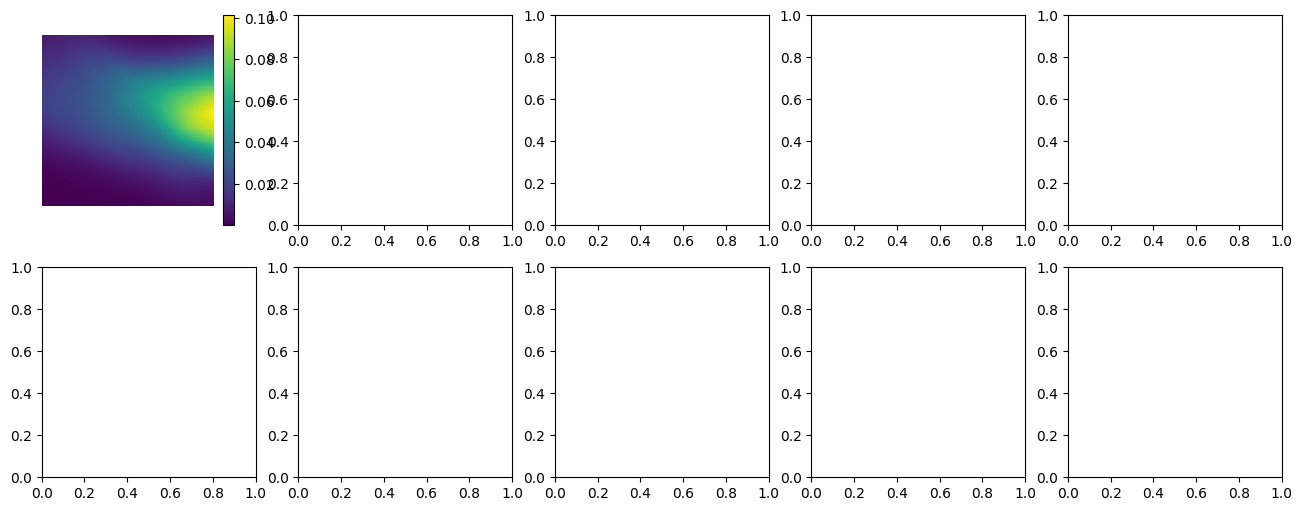

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=((16, 6)))
axs = axs.flatten()

for i in range(10):
    j = int(i * (inn_epochs / 200))
    epoch = int((i+1) * (inn_epochs / 10))
    if i == 10: j=-1
    e.contour_plot(freia_models[j], cvf=True, ax=axs[i])
    axs[i].set_title(f" {epoch} epochs (KL: {e.kldiv(models[j], cvf=True).mean().item():.2e})")

    axs[i].axis("off")
plt.tight_layout()
plt.show()

Result: FrEIA and Xavier initialization not necessary.

# Optuna Optimization for INN CVF Training

In [ ]:
def define_model(trial):
  hidden_dim = trial.suggest_categorical("hidden_dim", (4, 10, 20, 30))
  n_blocks = trial.suggest_categorical("n_blocks", (5, 10, 20, 32, 40))
  subnet_hidden_layers = trial.suggest_categorical("subnet_hidden_layers", (1, 2, 3))
  return m.realNVP(n_dim, hidden_dim, n_blocks, subnet_hidden_layers=subnet_hidden_layers)

def inn_objective(trial):
  model = define_model(trial).to(device)
  
  lr = trial.suggest_categorical("lr", (0.005, 0.001, 0.0005))
  batchsize = trial.suggest_categorical("batchsize", (64, 100, 256))

  _, metrics, _ = m.train_inn(model, batchsize=batchsize, epochs=3000, lr=lr)
  loss = np.mean(metrics["kl"][1][-5:])
  return loss

def run_study(study, objective, n_trials=20):
  study.optimize(objective, n_trials=n_trials, timeout=None)

  pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
  complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

  print("Study statistics: ")
  print("  Number of finished trials: ", len(study.trials))
  print("  Number of pruned trials: ", len(pruned_trials))
  print("  Number of complete trials: ", len(complete_trials))

  print("Best trial:")
  trial = study.best_trial

  print("  Value: ", trial.value)

  print("  Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
    
  fig = optuna.visualization.plot_param_importances(study)
  fig.show()

In [ ]:
inn_study = optuna.create_study(direction="minimize")
run_study(inn_study, inn_objective)

[I 2024-07-30 20:34:44,882] A new study created in memory with name: no-name-03f0b485-b16a-4c23-8c03-edbeae8a6559
100%|██████████| 3000/3000 [03:38<00:00, 13.73it/s]
[I 2024-07-30 20:38:23,472] Trial 0 finished with value: 0.004902969487011433 and parameters: {'hidden_dim': 10, 'n_blocks': 32, 'subnet_hidden_layers': 3, 'lr': 0.001, 'batchsize': 100}. Best is trial 0 with value: 0.004902969487011433.
100%|██████████| 3000/3000 [02:25<00:00, 20.60it/s]
[I 2024-07-30 20:40:49,162] Trial 1 finished with value: 0.006798175163567066 and parameters: {'hidden_dim': 4, 'n_blocks': 20, 'subnet_hidden_layers': 1, 'lr': 0.005, 'batchsize': 64}. Best is trial 0 with value: 0.004902969487011433.
100%|██████████| 3000/3000 [06:48<00:00,  7.34it/s]
[I 2024-07-30 20:47:38,242] Trial 2 finished with value: 0.0037207563873380423 and parameters: {'hidden_dim': 20, 'n_blocks': 20, 'subnet_hidden_layers': 3, 'lr': 0.0005, 'batchsize': 256}. Best is trial 2 with value: 0.0037207563873380423.
100%|██████████

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  0.0028331820853054524
  Params: 
    hidden_dim: 10
    n_blocks: 20
    subnet_hidden_layers: 1
    lr: 0.0005
    batchsize: 256
